# Event Detection Via Social Media Data
----
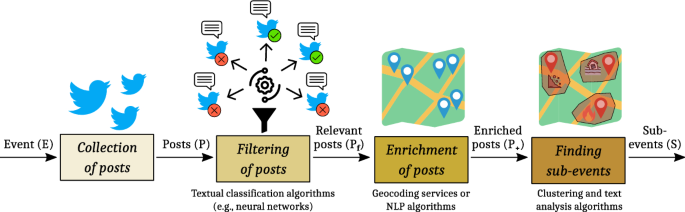

```
[Belcastro, L., Marozzo, F., Talia, D. et al. Using social media for sub-event detection during disasters. J Big Data 8, 79 (2021). https://doi.org/10.1186/s40537-021-00467-1]

```




## Table of Content

## Introduction

##Data Loading

In [ ]:
#@title Install Fast Text Model
# !pip install fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
!gunzip cc.ar.300.vec.gz


--2025-05-28 07:48:06--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.48, 18.173.166.51, 18.173.166.31, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  49.5MB/s    in 19s     

2025-05-28 07:48:25 (63.5 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [ ]:
#@title Install Packages
!pip install arabic-reshaper python-bidi
!pip install ar_wordcloud
!pip install transformers
!pip install stanza --quiet
# !pip install --upgrade scipy
!pip uninstall scipy

!pip install numpy --pre

!pip install gensim
import nltk
import stanza

nltk.download('stopwords')
from nltk.corpus import stopwords

arabic_stopwords = set(stopwords.words('arabic'))


# Download Arabic model once
stanza.download('ar', verbose=False)

# Initialize pipeline for Arabic with NER
nlp = stanza.Pipeline('ar', processors='tokenize,ner', use_gpu=True)


Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/scipy-1.13.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/scipy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so
    /usr/local/lib/python3.11/dist-packages/scipy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/scipy/*
Proceed (Y/n)? Y
  Successfully uninstalled scipy-1.13.1
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incom

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#@title import packages
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
from collections import Counter
import ast
import arabic_reshaper
from bidi.algorithm import get_display
from ar_wordcloud import ArabicWordCloud

import networkx as nx


In [ ]:
#@title Sentiment Analysis Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Sentiment Analysis model (3 classes: negative, neutral, positive)
sentiment_model_name = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)

# Map model output to labels
id2label = sentiment_model.config.id2label  # e.g., {0: 'negative', 1: 'neutral', 2: 'positive'}


# Apply sentiment analysis
def predict_sentiment(text):
    inputs = sentiment_tokenizer(text, return_tensors="pt", truncation=True, max_length=128,
        padding="max_length" )
    with torch.no_grad():
        outputs = sentiment_model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return id2label[prediction]
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentiment_model.to(device)

def batch_predict(texts, batch_size=32):
    all_predictions = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]

        inputs = sentiment_tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            max_length=128,
            padding="max_length"
        ).to(device)

        with torch.no_grad():
            outputs = sentiment_model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = [id2label[pred] for pred in predictions]
            all_predictions.extend(labels)

    return all_predictions

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
#@title Hate Speech Analysis Model
# Hate Speech model (2 classes: not hate, hate)
hate_model_name = "Hate-speech-CNERG/dehatebert-mono-arabic"
hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_name)
hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_name)

def batch_predict_hate(texts, batch_size=128):
    all_predictions = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]

        inputs = hate_tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            max_length=128,
            padding="max_length"
        ).to(device)

        with torch.no_grad():
            outputs = hate_model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_predictions.extend(predictions)  # 0: Not Hate, 1: Hate

    return all_predictions


In [ ]:
#@title uitlities
import re

def clean_tweet(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+', '', text)            # remove URLs
    text = re.sub(r'@\w+', '', text)                # remove mentions
    text = re.sub(r'#\w+', '', text)                # remove hashtags
    text = re.sub(r'[^ء-يa-zA-Z0-9\s]', ' ', text) # keep Arabic letters, Latin letters, numbers, and spaces only
    text = re.sub(r'\s+', ' ', text)                 # remove extra whitespace
    return text.strip()

def extract_entities_stanza(text):
    if not isinstance(text, str) or text.strip() == "":
        return []
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities

# Function to count hashtags in a tweet
def count_hashtags(text):
    return text.count('#')



In [ ]:
# @title Define Constants
urls = [
    "https://raw.githubusercontent.com/HasanKhadd0ur/SocialED_datasets/main/npy_data/Event2012.npy"
]

columns=[ 'tweet_id', 'text', 'event_id', 'words', 'filtered_words', 'entities', 'user_id', 'created_at', 'urls', 'hashtags', 'user_mentions']

In [ ]:
#@title read the data set
df = pd.read_csv("labeled.csv", encoding="utf-8")

In [ ]:
#@title Data

df.columns

Index(['Tweet ID', 'Tweet Text', 'Type', 'Author Name', 'Author Username',
       'Creation Time', 'Reply Count', 'Retweet Count', 'Quote Count',
       'Like Count', 'View Count', 'Bookmark Count', 'Language',
       'Possibly Sensitive', 'Source', 'Hashtags', 'Tweet URL', 'Media Type',
       'Media URLs', 'External URLs', 'Label'],
      dtype='object')

In [ ]:
# @title Ensure Type
# Ensure datetime format
df['Creation Time'] = pd.to_datetime(df['Creation Time'])


In [ ]:
# @title Data shape
print(df.shape)


(4226, 21)


## Explore Dataset

In [ ]:
#@title Clean the tweet texts
df['Old Tweet Text'] = df['Tweet Text']
df['Tweet Text'] = df['Tweet Text'].apply(clean_tweet)


In [ ]:
#@title Some Sampels From the Dataset
df.sample(2)

,Label,Tweet ID,Tweet Text,Type,Author Name,Author Username,Creation Time,Reply Count,Retweet Count,Quote Count,...,Bookmark Count,Language,Possibly Sensitive,Source,Hashtags,Tweet URL,Media Type,Media URLs,External URLs,Old Tweet Text
1338,1,1.921208e+18,طريق دير الزور دمشق المفترض أنه طريق دولي هو ف...,Reply,محمد زيد الطائي ????????,Muhammed_altaei,2025-05-10 17:17:43,0.0,0.0,0.0,...,0.0,ar,No,Twitter for iPhone,NaN,https://x.com/Muhammed_altaei/status/192120802...,NaN,NaN,NaN,@AlekhbariahSY طريق دير الزور - دمشق، المفترض ...
2756,0,1.925251e+18,دويلة دمشق لا تستيطع حتى حماية محافظيها,Reply,Lloyd Atallah,Lloyd__Atallah,2025-05-21 21:03:59,0.0,0.0,0.0,...,0.0,ar,No,Twitter Web App,NaN,https://x.com/Lloyd__Atallah/status/1925251239...,NaN,NaN,NaN,@shibl91 دويلة دمشق لا تستيطع حتى حماية محافظ...


In [ ]:
# @title Check for missing values
# Basic DataFrame info
df.info()

# # Check for missing values
# print("\nMissing values per column:\n", df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Label               4222 non-null   object        
 1   Tweet ID            4225 non-null   float64       
 2   Tweet Text          4226 non-null   object        
 3   Type                4225 non-null   object        
 4   Author Name         2005 non-null   object        
 5   Author Username     2005 non-null   object        
 6   Creation Time       4225 non-null   datetime64[ns]
 7   Reply Count         4225 non-null   float64       
 8   Retweet Count       4225 non-null   float64       
 9   Quote Count         4225 non-null   float64       
 10  Like Count          4225 non-null   float64       
 11  View Count          4150 non-null   float64       
 12  Bookmark Count      4225 non-null   float64       
 13  Language            4225 non-null   object      

In [ ]:
# @title Drop rows with missing Label values
df = df.dropna(subset=["Label"])
df = df[df['Label'].isin(['0', '1'])]


In [ ]:
# @title Check for missing values
# Basic DataFrame info
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4221 entries, 0 to 4225
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Label               4221 non-null   object 
 1   Tweet ID            4221 non-null   float64
 2   Tweet Text          4221 non-null   object 
 3   Type                4221 non-null   object 
 4   Author Name         2002 non-null   object 
 5   Author Username     2002 non-null   object 
 6   Creation Time       4221 non-null   object 
 7   Reply Count         4221 non-null   float64
 8   Retweet Count       4221 non-null   float64
 9   Quote Count         4221 non-null   float64
 10  Like Count          4221 non-null   float64
 11  View Count          4146 non-null   float64
 12  Bookmark Count      4221 non-null   float64
 13  Language            4221 non-null   object 
 14  Possibly Sensitive  4221 non-null   object 
 15  Source              4221 non-null   object 
 16  Hashtags   

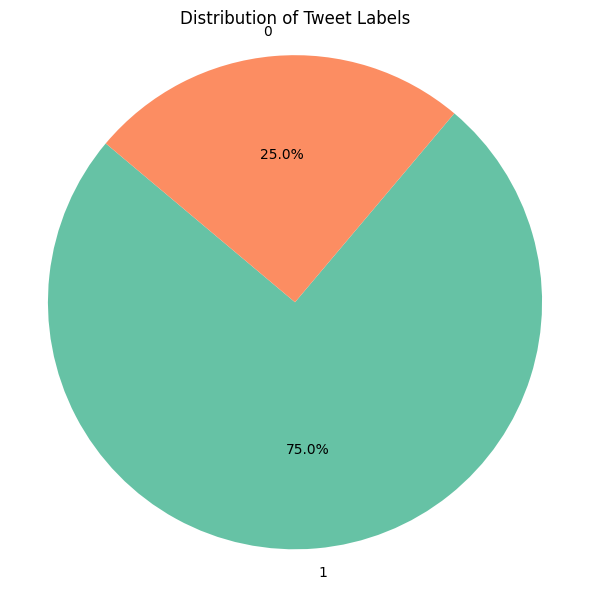

In [ ]:

# @title Plot the distribution of the label values
# Plot the distribution of the label values as a pie chart
plt.figure(figsize=(6, 6))
label_counts = df['Label'].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Distribution of Tweet Labels')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.tight_layout()
plt.show()


In [ ]:
# @title The Range of the data
print(df["Creation Time"].min(), df["Creation Time"].max())

1/10/2025, 2:47:17 PM 9/5/2024, 9:22:20 PM


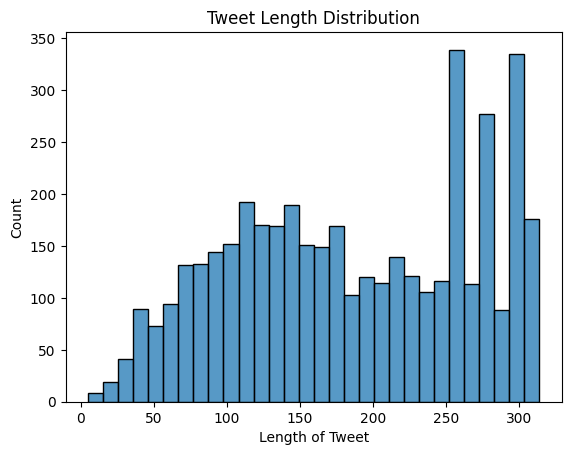

In [ ]:
#@title Tweet length distribution
df['text_length'] = df['Tweet Text'].apply(len)
# df['text_length'].describe()

# Plot distribution
# plt.figure(figsize=(10, 6))
# sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue')
# plt.title('Distribution of Tweet Lengths')
# plt.xlabel('Tweet Length')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()
sns.histplot(df['text_length'], bins=30)
plt.title('Tweet Length Distribution')
plt.xlabel('Length of Tweet')
plt.ylabel('Count')
plt.show()

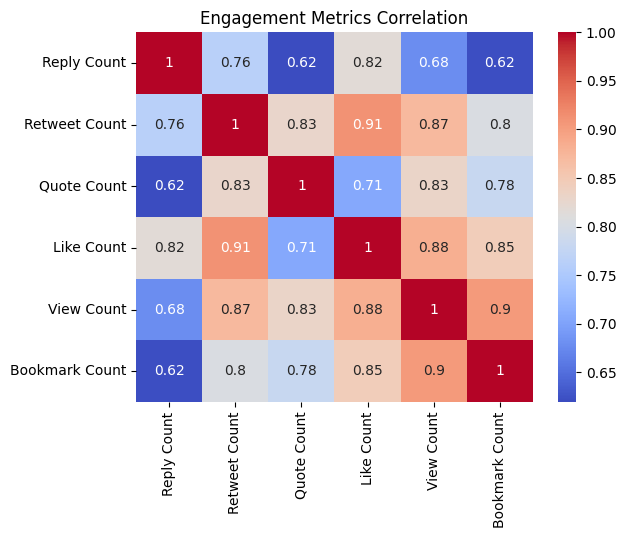

In [ ]:
#@title Correlation Heat Map
engagement_cols = ['Reply Count', 'Retweet Count', 'Quote Count', 'Like Count', 'View Count', 'Bookmark Count']
df[engagement_cols].describe()

# Correlation heatmap
sns.heatmap(df[engagement_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Engagement Metrics Correlation')
plt.show()


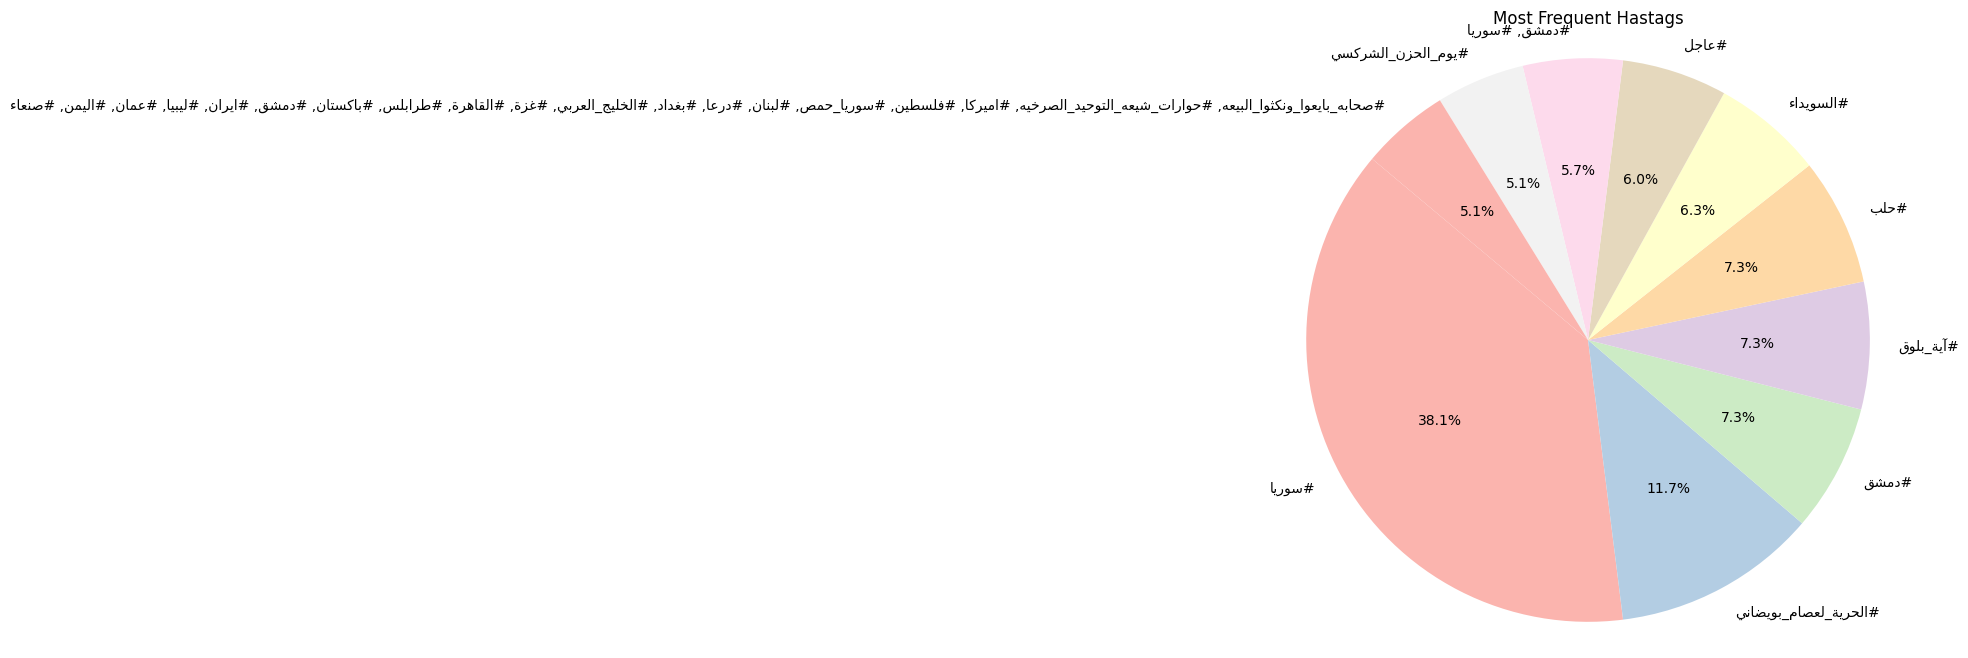

In [ ]:
#@title Frequent Hashtags
# Prepare hashtag counts
all_hashtags = df['Hashtags'].dropna().apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [x])
flattened = [tag for sublist in all_hashtags for tag in sublist]
hashtag_counts = Counter(flattened)

# Extract top 10 hashtags
top_hashtags = hashtag_counts.most_common(10)
labels, counts = zip(*top_hashtags)

# Reshape and reorder Arabic labels
reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in labels]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=reshaped_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title("Most Frequent Hastags")
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.show()


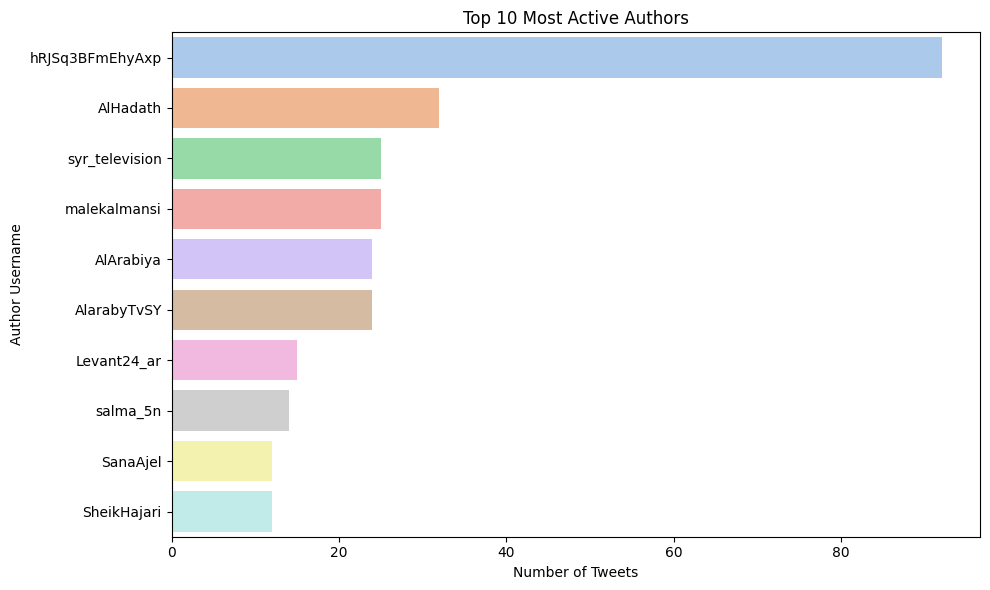

In [ ]:
# @title Most active authors

top_authors = df['Author Username'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors.values, y=top_authors.index, palette='pastel',hue=top_authors.index)
plt.title('Top 10 Most Active Authors')
plt.xlabel('Number of Tweets')
plt.ylabel('Author Username')
plt.tight_layout()
plt.show()

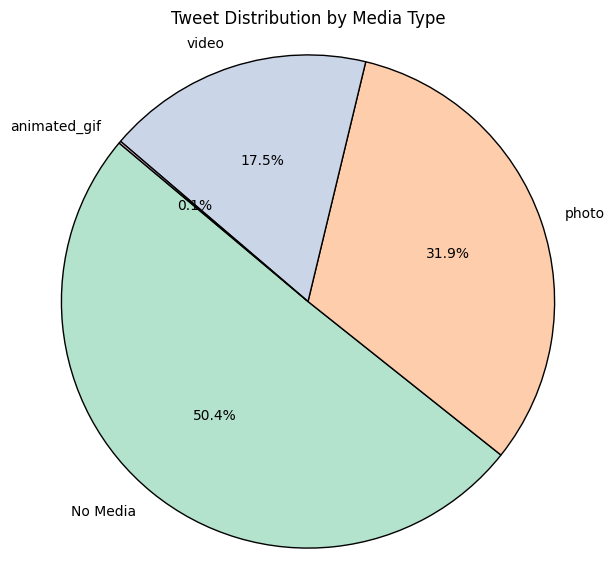

In [ ]:
#@title Media Type
import matplotlib.pyplot as plt

# Get media type counts including NaNs
media_counts = df['Media Type'].value_counts(dropna=False)

# Replace NaN label with 'No Media'
media_counts.index = media_counts.index.fillna('No Media')

plt.figure(figsize=(7,7))
plt.pie(
    media_counts,
    labels=media_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Pastel2.colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Tweet Distribution by Media Type')
plt.axis('equal')
plt.show()



In [ ]:
#@title External URLs presence
ext_urls=df['External URLs'].notnull().sum()
print(f"Number of tweets with external URLs: {ext_urls}")

Number of tweets with external URLs: 281


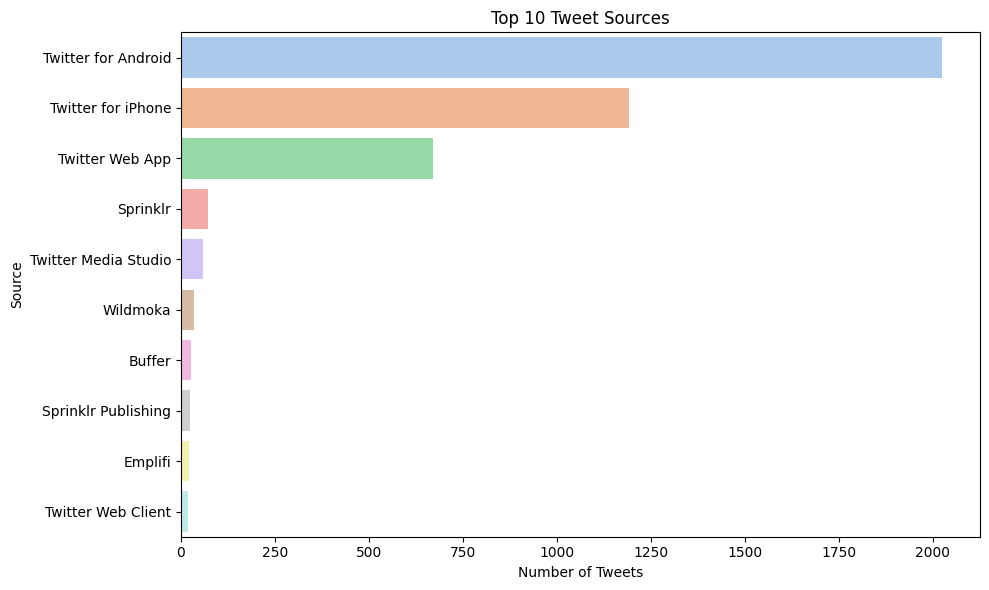

In [ ]:

#@title Most common sources (devices/apps used)

# Get top 10 sources
top_sources = df['Source'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_sources.values, y=top_sources.index, palette='pastel',hue=top_sources.index)
plt.title('Top 10 Tweet Sources')
plt.xlabel('Number of Tweets')
plt.ylabel('Source')
plt.tight_layout()
plt.show()

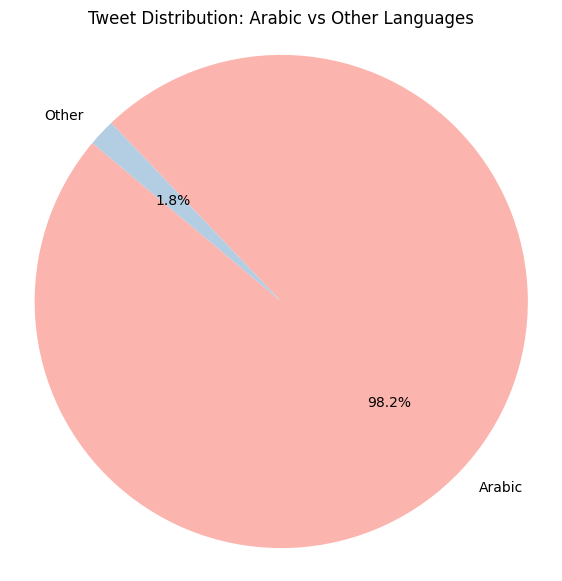

In [ ]:
#@title Languages Distribution
# Count languages
language_counts = df['Language'].value_counts()

arabic_lang = 'ar'  # change if needed
arabic_count = language_counts.get(arabic_lang, 0)

# Sum of all non-Arabic languages
other_count = language_counts.sum() - arabic_count

# Create series for pie chart
pie_counts = [arabic_count, other_count]
labels = ['Arabic', 'Other']

# Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(pie_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Tweet Distribution: Arabic vs Other Languages')
plt.axis('equal')  # Make pie circular
plt.show()


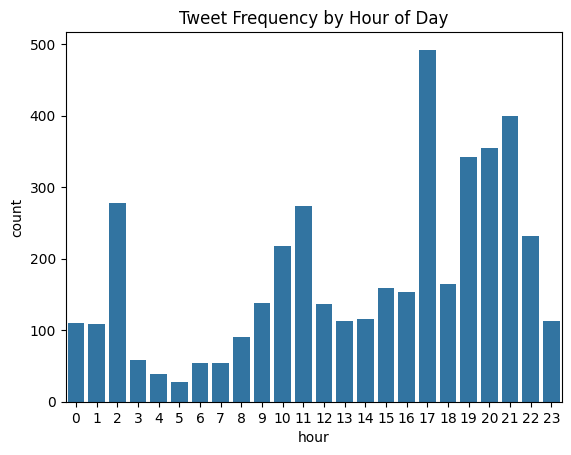

In [ ]:
# @title Tweet Frequency by Hour
# Extract hour and date
df['hour'] = df['Creation Time'].dt.hour
df['date'] = df['Creation Time'].dt.date

# Plot tweet frequency by hour
sns.countplot(x='hour', data=df)
plt.title('Tweet Frequency by Hour of Day')
plt.show()


<ipython-input-100-2e1a0f503a1e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_df['Word Count'] = day_df['Tweet Text'].str.split().apply(len)


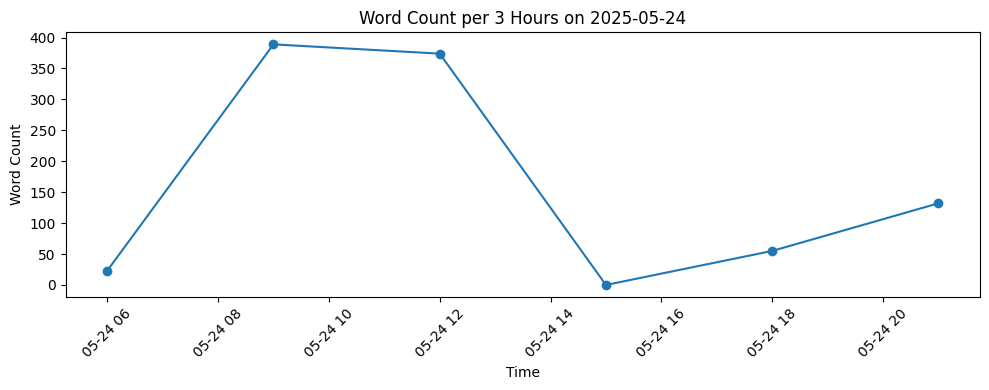

In [ ]:
# @title Word Count per 3 Hours on A Day
# Select a specific date (e.g., May 21, 2025)
selected_day = '2025-05-24'
day_df = df[df['Creation Time'].dt.date == pd.to_datetime(selected_day).date()]

# Create a new column with word count
day_df['Word Count'] = day_df['Tweet Text'].str.split().apply(len)

# Set datetime index to resample
day_df = day_df.set_index('Creation Time')

# Resample every 3 hours and sum word counts
word_counts_3h = day_df['Word Count'].resample('3h').sum()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(word_counts_3h.index, word_counts_3h.values, marker='o')
plt.title(f'Word Count per 3 Hours on {selected_day}')
plt.xlabel('Time')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

downloading and unzipping arabic font: /usr/local/lib/python3.11/dist-packages/ar_wordcloud/fonts/NotoNaskhArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.11/dist-packages/ar_wordcloud/fonts/NotoSansArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.11/dist-packages/ar_wordcloud/fonts/NotoKufiArabic-unhinted.zip .. 


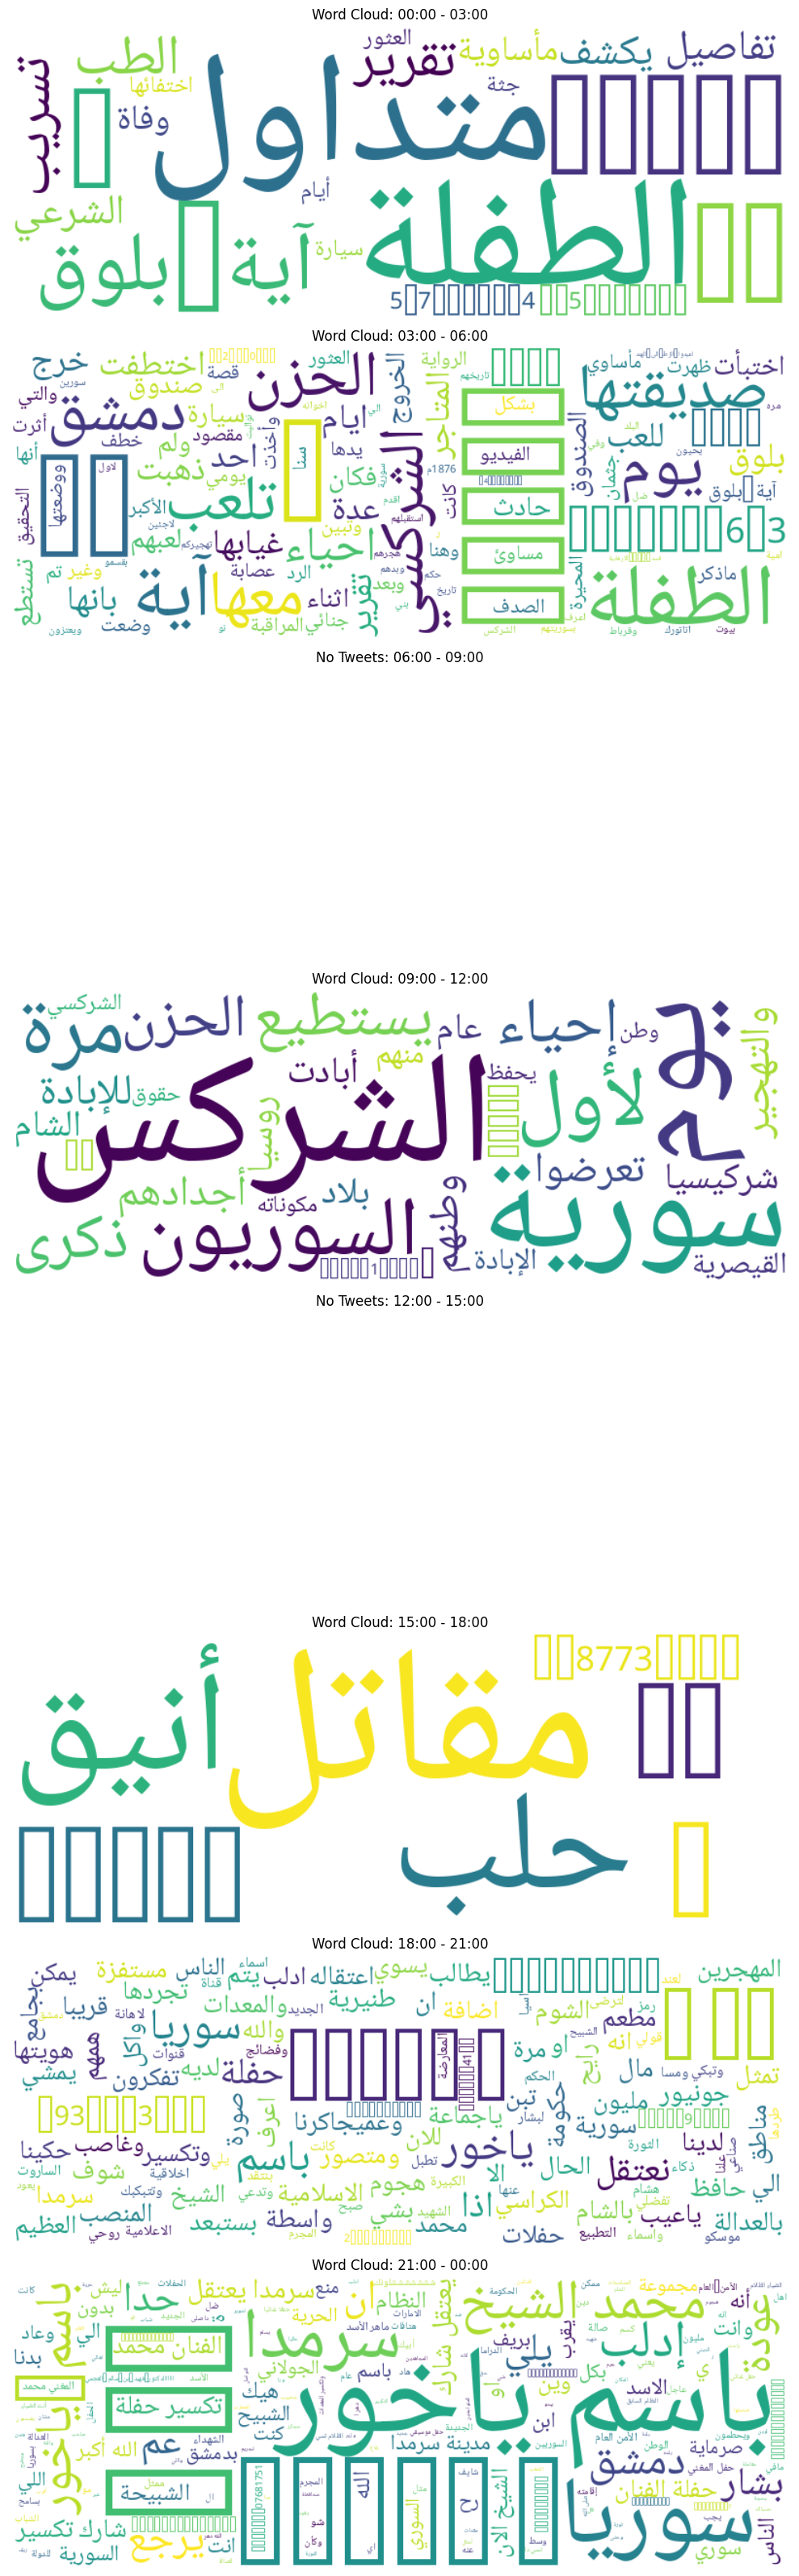

In [ ]:
#@title  word cloud for a day
# Filter tweets for the selected day first
selected_day = '2025-05-23'
day_df = df[df['Creation Time'].dt.date == pd.to_datetime(selected_day).date()].copy()
day_df = day_df.set_index('Creation Time')

# Resample every 3 hours
intervals = list(day_df.resample('3h'))

# Create subplots
fig, axs = plt.subplots(len(intervals), 1, figsize=(10, 4 * len(intervals)))
if len(intervals) == 1:
    axs = [axs]

for i, (time_bin, group) in enumerate(intervals):
    # Join all tweet texts into one string
    all_text = ' '.join(group['Tweet Text'].dropna().astype(str))

    if all_text.strip():
        # Remove stop words
        words = all_text.split()
        filtered_words = [w for w in words if w not in arabic_stopwords]
        filtered_text = ' '.join(filtered_words)

        # Generate Arabic word cloud
        wc = ArabicWordCloud(
            width=800,
            height=300,
            background_color='white'
        ).generate(filtered_text)

        axs[i].imshow(wc, interpolation='bilinear')
        axs[i].axis('off')
        axs[i].set_title(f'Word Cloud: {time_bin.strftime("%H:%M")} - {(time_bin + pd.Timedelta(hours=3)).strftime("%H:%M")}')
    else:
        axs[i].axis('off')
        axs[i].set_title(f'No Tweets: {time_bin.strftime("%H:%M")} - {(time_bin + pd.Timedelta(hours=3)).strftime("%H:%M")}')

plt.tight_layout()
plt.show()


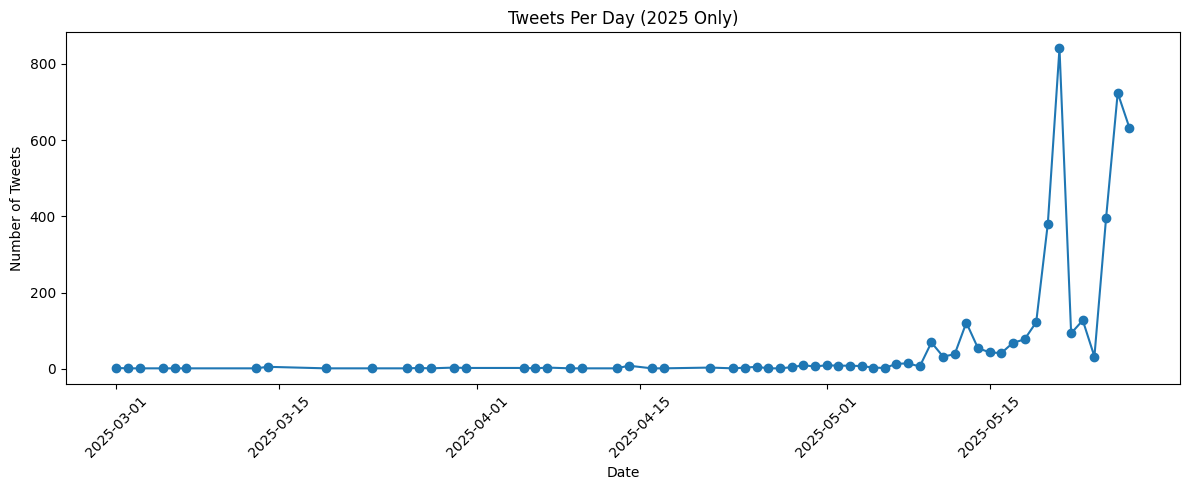

In [ ]:
#@title Tweets Per Day

# Ensure 'date' column is of type Timestamp
df['date'] = pd.to_datetime(df['date'])

# Filter only tweets from 2025 onwards
df_filtered = df[df['date'] >= pd.Timestamp('2025-3-01')]

# Count tweets per day
daily_counts = df_filtered['date'].value_counts().sort_index()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.title('Tweets Per Day (2025 Only)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


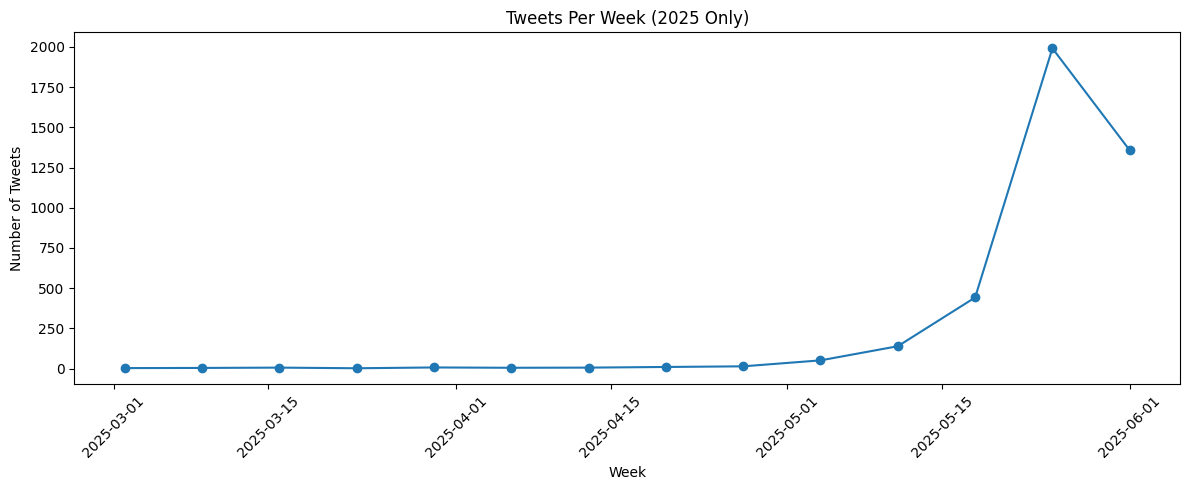

In [ ]:
# @title Tweets Per Week
# Filter only tweets from 2025
df_filtered = df[df['date'] >= pd.Timestamp('2025-03-01')]

# Set 'date' as index for resampling
df_filtered = df_filtered.set_index('date')

# Group by week and count tweets
weekly_counts = df_filtered.resample('W').size()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(weekly_counts.index, weekly_counts.values, marker='o')
plt.title('Tweets Per Week (2025 Only)')
plt.xlabel('Week')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-108-06d477f9f35a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x='Label', palette='Set1')


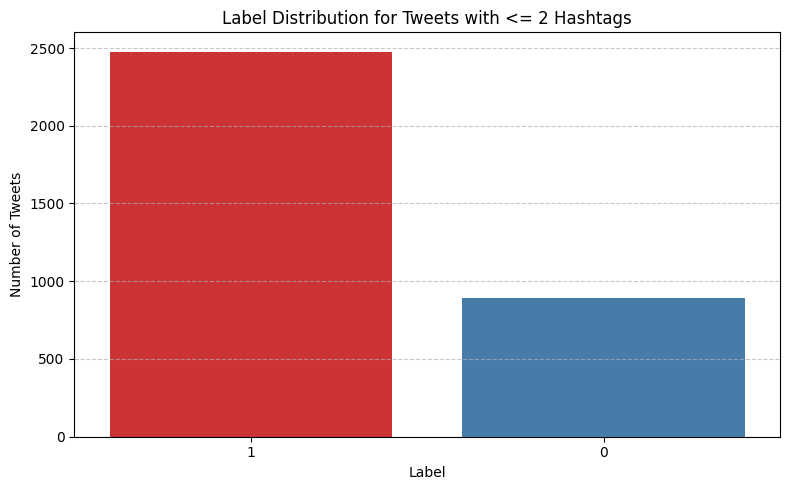

In [ ]:
#@title Hashtag Count

# Create a new column for hashtag counts
df['HashtagCount'] = df['Tweet Text'].apply(count_hashtags)

# Filter tweets with more than 4 hashtags
df_filtered = df[df['HashtagCount'] <=2]

# Plot the label distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df_filtered, x='Label', palette='Set1')
plt.title('Label Distribution for Tweets with <= 2 Hashtags')
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


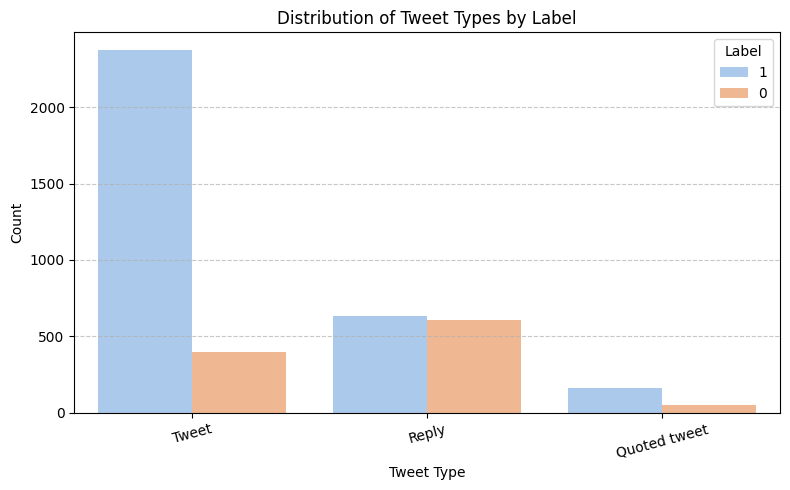

In [ ]:
#@title Tweets Type
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Type', hue='Label', palette='pastel')

plt.title('Distribution of Tweet Types by Label')
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.legend(title='Label', loc='upper right')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



100%|██████████| 132/132 [37:49<00:00, 17.20s/it]


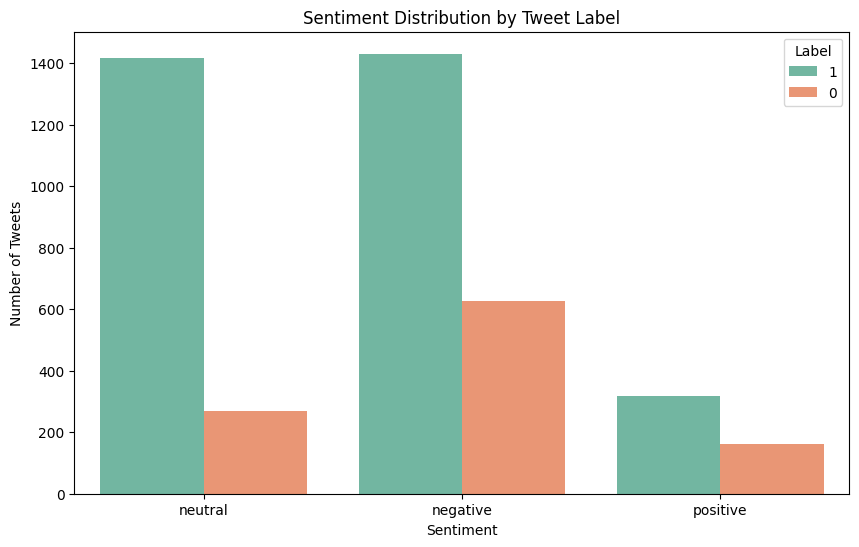

In [ ]:
#@title Sentiment Analysis
# Run sentiment analysis (this might take time if the dataset is large)
df['Sentiment'] = batch_predict(df['Tweet Text'].tolist())

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Sentiment', hue='Label', palette='Set2')
plt.title('Sentiment Distribution by Tweet Label')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.legend(title='Label', loc='upper right')

In [ ]:
#@title Perdicate Sentiment
# df['Sentiment'] = df['Tweet Text'].apply(predict_sentiment)

df['Sentiment'] = batch_predict(df['Tweet Text'].tolist(), batch_size=32)


100%|██████████| 312/312 [1:06:01<00:00, 12.70s/it]


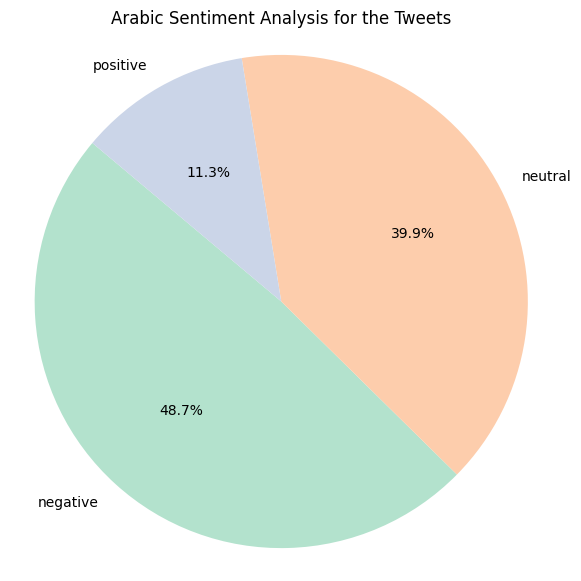

In [ ]:

# @title Plot sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()
labels = sentiment_counts.index.tolist()
counts = sentiment_counts.values.tolist()

# Plot
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel2.colors)
plt.title("Arabic Sentiment Analysis for the Tweets")
plt.axis('equal')
plt.show()

In [ ]:
#@title Hate Speech Detection
df['HateSpeech'] = batch_predict_hate(df['Tweet Text'].tolist(), batch_size=64)

100%|██████████| 66/66 [29:48<00:00, 27.09s/it]


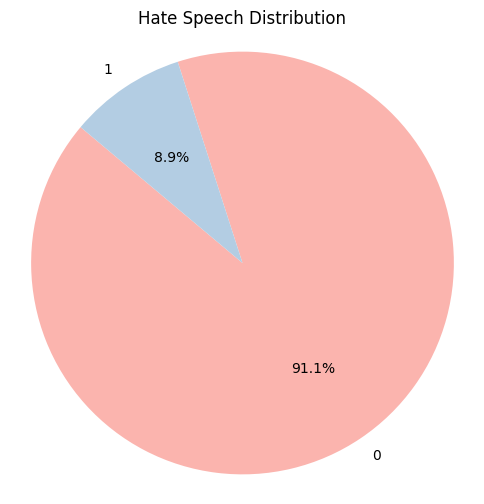

In [ ]:
#@title Hate Speach Distribution
counts = df['HateSpeech'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title("Hate Speech Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


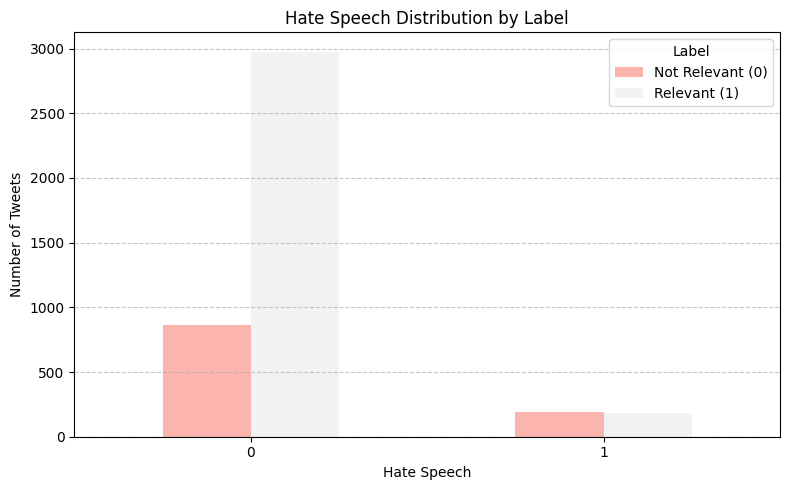

In [ ]:
#@title Hate Speech Distribution
# Create a crosstab of HateSpeech vs Label
hate_label_dist = pd.crosstab(df['HateSpeech'], df['Label'])

# Plot
hate_label_dist.plot(
    kind='bar',
    stacked=False,
    figsize=(8, 5),
    colormap='Pastel1'
)

plt.title("Hate Speech Distribution by Label")
plt.xlabel("Hate Speech")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=0)
plt.legend(title='Label', labels=['Not Relevant (0)', 'Relevant (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#@title Extract Named Entites
from concurrent.futures import ThreadPoolExecutor

# Use ThreadPool to speed up processing
texts = df['Tweet Text'].tolist()

with ThreadPoolExecutor(max_workers=8) as executor:
    named_entities = list(executor.map(extract_entities_stanza, texts))

df['Named Entities'] = named_entities


In [ ]:
#@title Some Named Entities
df['Named Entities'].sample(4)

,Named Entities
1406,"[مخيم الهول, دير الزور]"
111,[]
1121,"[المرصد السوري, حلب, قوات سوريا الديمقراطية, ح..."
313,"[بورتسودان, الإمارات]"


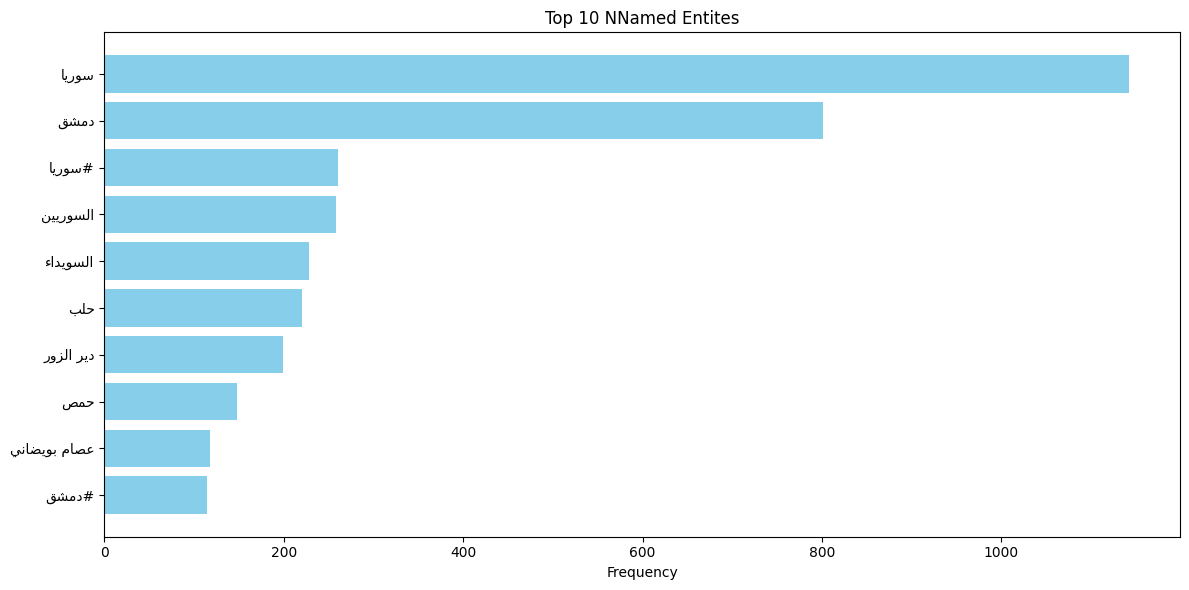

In [ ]:
#@title Top Named Entities
# Flatten all named entities from the dataframe column into a single list
all_entities = [ent for sublist in df['Named Entities'] for ent in sublist]

# Count frequency of each entity
entity_counts = Counter(all_entities)

# Get top 10 entities and their counts
top_entities = entity_counts.most_common(10)
entities, counts = zip(*top_entities)

# Reshape and reorder Arabic entity labels for correct display
reshaped_entities = [get_display(arabic_reshaper.reshape(ent)) for ent in entities]

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.barh(reshaped_entities[::-1], counts[::-1], color='skyblue')  # reversed for descending order
plt.xlabel('Frequency')
plt.title("Top 10 NNamed Entites")
plt.tight_layout()
plt.show()


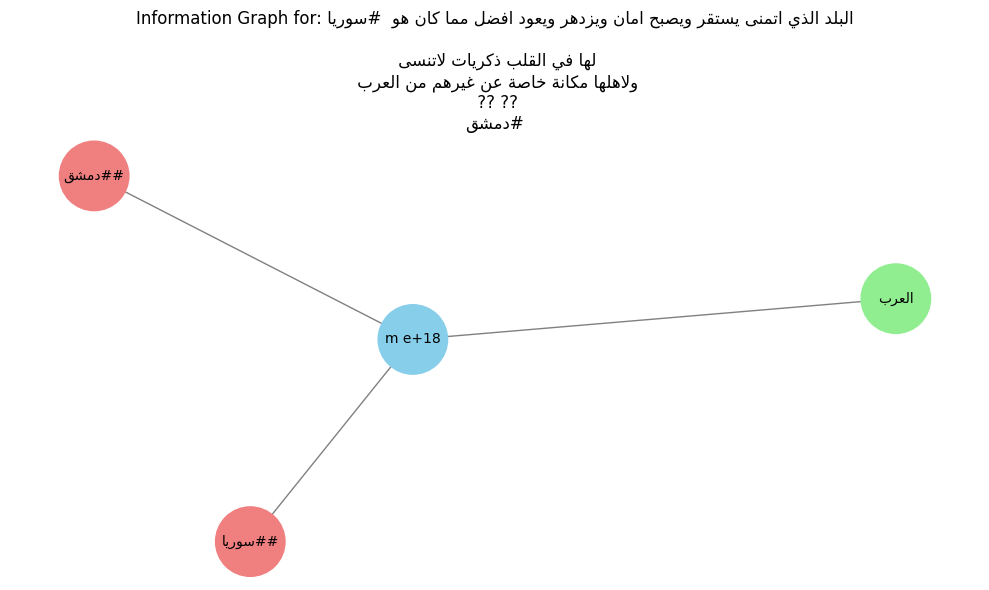

In [ ]:
#@title Message Attribute Graph for un relevant tweet
import networkx as nx
import matplotlib.pyplot as plt
import random
import arabic_reshaper
from bidi.algorithm import get_display

# Choose a single tweet randomly from your dataframe
random.seed(2342)
random_idx = random.choice(df.index)

irrelevant_df = df[df['Label'] == 0]

row = irrelevant_df.sample(1).iloc[0]

# Determine the entity column name
if 'Named Entities' in df.columns:
    entity_col = 'Named Entities'
elif 'entities' in df.columns:
    entity_col = 'entities'
else:
    raise ValueError("No entity column found; please check your dataframe")

G = nx.Graph()
# Create node for the tweet
tweet_node = f"m {str(row['Tweet ID'])[-4:]}"  # last 4 chars of Tweet ID
G.add_node(tweet_node, label='tweet', color='skyblue')

# Add entity nodes and edges
entities = row.get(entity_col, [])
if not isinstance(entities, list):
    entities = []

for entity in entities:
    if isinstance(entity, (tuple, list)):
        entity_text = str(entity[0]).strip()
    else:
        entity_text = str(entity).strip()

    # Reshape and reorder Arabic text for correct display
    reshaped_text = arabic_reshaper.reshape(entity_text)
    display_text = get_display(reshaped_text)

    G.add_node(display_text, label='entity', color='lightgreen')
    G.add_edge(tweet_node, display_text)

# Add hashtag nodes and edges
hashtags = row.get('Hashtags', [])
if not isinstance(hashtags, list):
    if isinstance(hashtags, str):
        if ',' in hashtags:
            hashtags = [h.strip() for h in hashtags.split(',') if h.strip()]
        else:
            hashtags = [h.strip() for h in hashtags.split() if h.strip()]
    else:
        hashtags = []

for hashtag in hashtags:
    hashtag_text = f"#{hashtag.strip().lower()}"
    reshaped_text = arabic_reshaper.reshape(hashtag_text)
    display_text = get_display(reshaped_text)

    G.add_node(display_text, label='hashtag', color='lightcoral')
    G.add_edge(tweet_node, display_text)

# Plotting the graph
pos = nx.spring_layout(G, seed=42)
node_colors = [data['color'] for _, data in G.nodes(data=True)]

plt.figure(figsize=(10, 6))
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    font_size=10,
    node_size=2500,
    edge_color='gray'
)
plt.title(f"Information Graph for: {get_display(arabic_reshaper.reshape(row['Tweet Text']))}")
plt.axis('off')
plt.tight_layout()
plt.show()


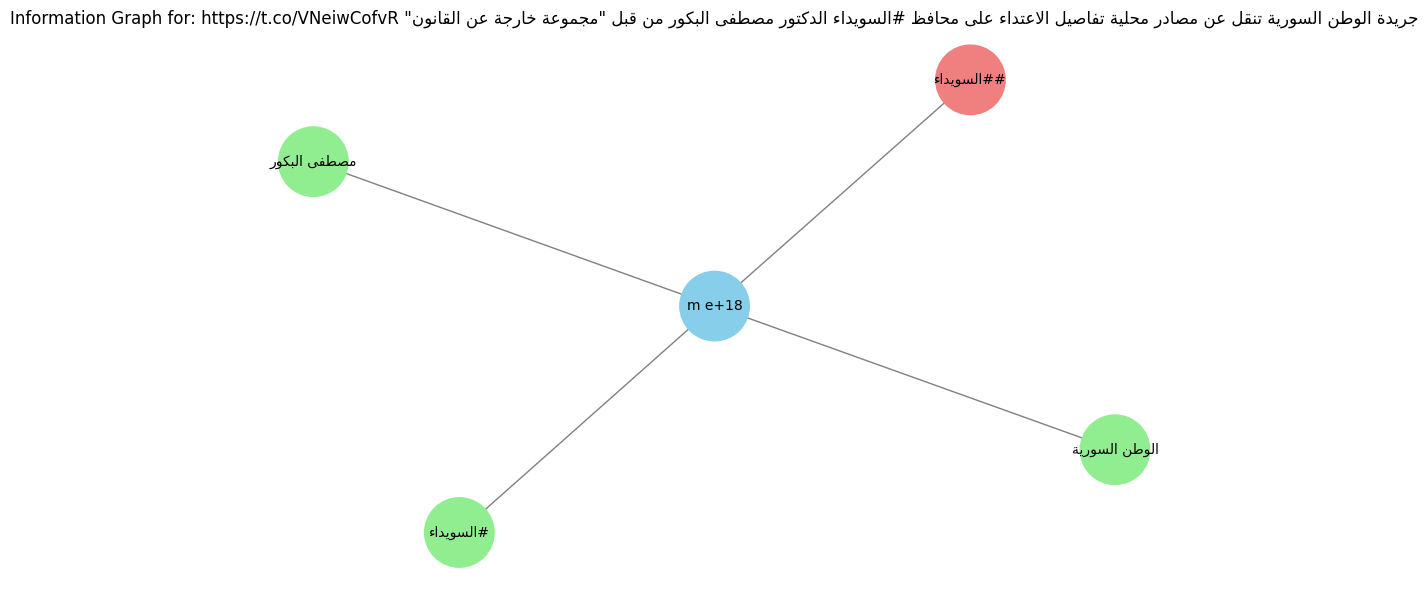

In [ ]:
#@title Message Attribute Graph for relevant tweet
import networkx as nx
import matplotlib.pyplot as plt
import random
import arabic_reshaper
from bidi.algorithm import get_display

# Choose a single tweet randomly from your dataframe
random.seed(2342)
random_idx = random.choice(df.index)

irrelevant_df = df[df['Label'] == 1]

row = irrelevant_df.sample(1).iloc[0]

# Determine the entity column name
if 'Named Entities' in df.columns:
    entity_col = 'Named Entities'
elif 'entities' in df.columns:
    entity_col = 'entities'
else:
    raise ValueError("No entity column found; please check your dataframe")

G = nx.Graph()
# Create node for the tweet
tweet_node = f"m {str(row['Tweet ID'])[-4:]}"  # last 4 chars of Tweet ID
G.add_node(tweet_node, label='tweet', color='skyblue')

# Add entity nodes and edges
entities = row.get(entity_col, [])
if not isinstance(entities, list):
    entities = []

for entity in entities:
    if isinstance(entity, (tuple, list)):
        entity_text = str(entity[0]).strip()
    else:
        entity_text = str(entity).strip()

    # Reshape and reorder Arabic text for correct display
    reshaped_text = arabic_reshaper.reshape(entity_text)
    display_text = get_display(reshaped_text)

    G.add_node(display_text, label='entity', color='lightgreen')
    G.add_edge(tweet_node, display_text)

# Add hashtag nodes and edges
hashtags = row.get('Hashtags', [])
if not isinstance(hashtags, list):
    if isinstance(hashtags, str):
        if ',' in hashtags:
            hashtags = [h.strip() for h in hashtags.split(',') if h.strip()]
        else:
            hashtags = [h.strip() for h in hashtags.split() if h.strip()]
    else:
        hashtags = []

for hashtag in hashtags:
    hashtag_text = f"#{hashtag.strip().lower()}"
    reshaped_text = arabic_reshaper.reshape(hashtag_text)
    display_text = get_display(reshaped_text)

    G.add_node(display_text, label='hashtag', color='lightcoral')
    G.add_edge(tweet_node, display_text)

# Plotting the graph
pos = nx.spring_layout(G, seed=42)
node_colors = [data['color'] for _, data in G.nodes(data=True)]

plt.figure(figsize=(10, 6))
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    font_size=10,
    node_size=2500,
    edge_color='gray'
)
plt.title(f"Information Graph for: {get_display(arabic_reshaper.reshape(row['Tweet Text']))}")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
#@title Remove Non Arabic Tweets
# Keep only Arabic tweets based on the 'Language' column
df = df[df['Language'] == 'ar'].reset_index(drop=True)


In [ ]:
# @title Saving The Data Set
df.to_csv("processed_labeled.csv")

## Text Embedding with Fast Text


In [ ]:
#@title Fix Dependency Issue
!pip install scipy==1.10.1
!pip uninstall -y numpy gensim
!pip install numpy==1.24.3 gensim==4.3.1



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.10.1 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.1 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scip

In [ ]:
#@title Load the model
from gensim.models import KeyedVectors

# Load the .vec file (pre-trained FastText embeddings in text format)
fasttext_model = KeyedVectors.load_word2vec_format('cc.ar.300.vec', binary=False, encoding='utf-8')


In [ ]:
#@title Embedding the DF
import numpy as np

def embed_tweet(text, model):
    words = text.split()  # simple tokenization; you can replace with better Arabic tokenizer
    word_vectors = []

    for word in words:
        if word in model.key_to_index:
            word_vectors.append(model[word])
        else:
            # A zero vector if the word is OOV (out of vocab)
            word_vectors.append(np.zeros(model.vector_size))

    if word_vectors:
        # Aggregate word vectors by averaging
        tweet_vector = np.mean(word_vectors, axis=0)
    else:
        # Empty or no known words → zero vector
        tweet_vector = np.zeros(model.vector_size)

    return tweet_vector

# Apply embedding to entire DataFrame column, create new column with vectors
df['tweet_embedding'] = df['Tweet Text'].apply(lambda text: embed_tweet(text, fasttext_model))

# Example: check vector shape for first tweet
print(df['tweet_embedding'].iloc[0].shape)


(300,)


### Sipliting the Dataset

In [ ]:
X = np.vstack(df['tweet_embedding'].values)
y = df['Label'].values


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### KNN

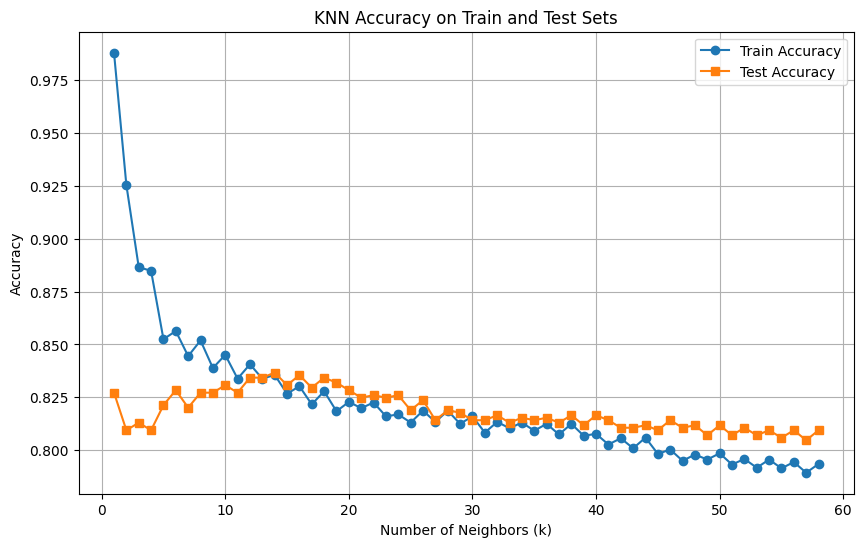

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from math import sqrt

# Number of training samples
n_train = X_train.shape[0]

# Maximum k to try: integer part of sqrt(n_train)
max_k = int(sqrt(n_train))

# Store accuracies for train and test
train_accuracies = []
test_accuracies = []

k_values = range(1, max_k + 1)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict on train set and test set
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy on Train and Test Sets')
plt.legend()
plt.grid(True)
plt.show()


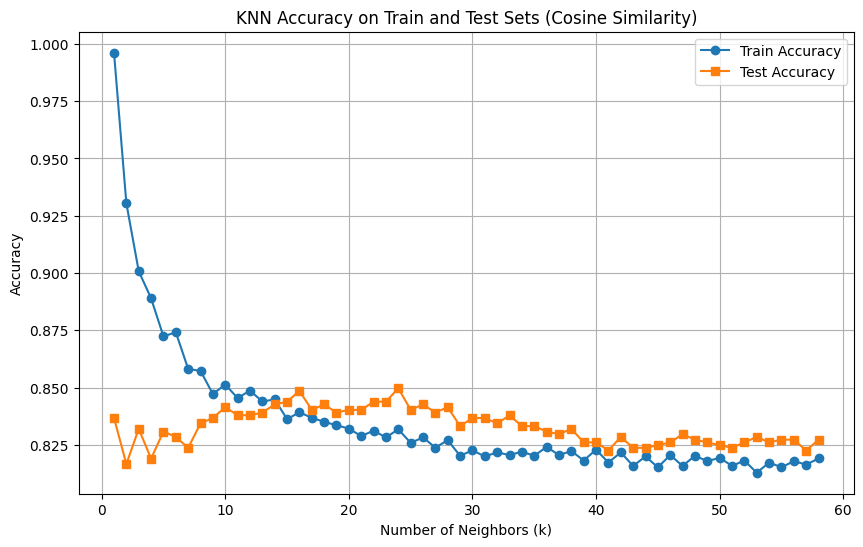

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from math import sqrt

# Number of training samples
n_train = X_train.shape[0]

# Maximum k to try: integer part of sqrt(n_train)
max_k = int(sqrt(n_train))

# Store accuracies for train and test
train_accuracies = []
test_accuracies = []

k_values = range(1, max_k + 1)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(X_train, y_train)

    # Predict on train set and test set
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy on Train and Test Sets (Cosine Similarity)')
plt.legend()
plt.grid(True)
plt.show()


### SVM

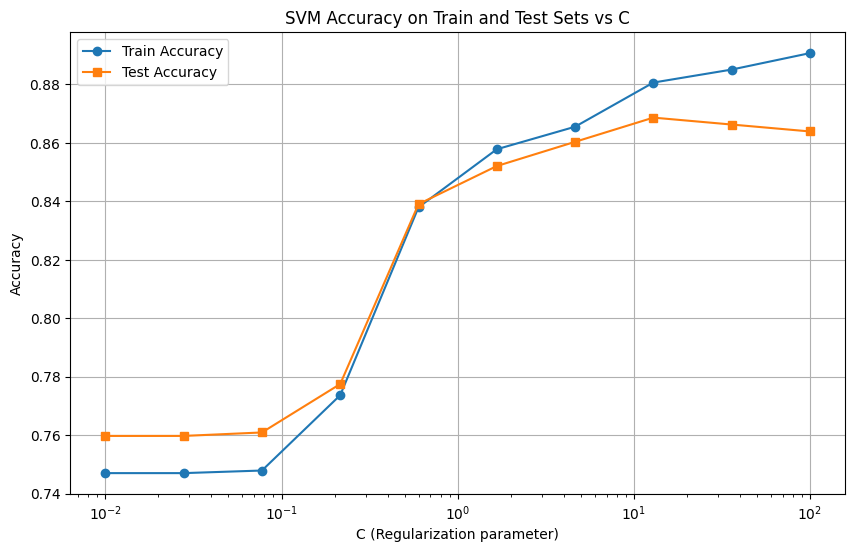

In [ ]:
#@title SVM with Linear kernel (jsut to show a base line )
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a range of C values to try (log scale)
C_values = np.logspace(-2, 2, 10)  # 0.01 to 100

train_accuracies = []
test_accuracies = []

for C in C_values:
    svm = SVC(C=C, kernel='linear')  # using linear kernel, you can try others like 'rbf'
    svm.fit(X_train, y_train)

    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(C_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xscale('log')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy on Train and Test Sets vs C')
plt.legend()
plt.grid(True)
plt.show()


## Conclusion